In [ ]:
#Current Definition of Impaired

    IM_idx = list(set([i[0] for i in Occ_DF[(Occ_DF.PER_TYPE==1) & (Occ_DF.DR_CON.isin([2,3,6,7]))].index]))
    EADict.update({'EA_IM':IM_idx})

In [1]:
# Importing requird python packages
# Path to hsmpy package
HSMPY_PATH = r'\\CHCFPP01\Guest\MRajabi\Python Scripts'
import sys, os, arcpy, csv, json, math
sys.path.append(HSMPY_PATH)
import hsmpy3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from IPython.display import Image
from IPython.core.display import HTML 
import subprocess 
import webbrowser
import time
import copy
import scipy
from matplotlib.gridspec import GridSpec
from mailmerge import MailMerge
import shutil
import openpyxl
from scipy.optimize import curve_fit
from time import gmtime, strftime
from ipywidgets import FloatProgress
print(strftime("%Y-%m-%d %H:%M:%S"))

2018-11-20 15:16:05


In [ ]:
DB_Dir = r'\\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\7_BaseData\Master_BaseFiles_Data\9.0_IL_SafetyDB'
print(strftime("%Y-%m-%d %H:%M:%S"))

In [ ]:
#Read Crash Data
print(strftime("%Y-%m-%d %H:%M:%S"))
Crash_DF = pd.DataFrame()
Veh_DF = pd.DataFrame()
Occ_DF = pd.DataFrame()
for year in range(2005,2017):
    df = pd.read_csv(DB_Dir+'\\{}_Crash_Assigned.csv'.format(year),index_col=0)
    df['DATE'] = pd.to_datetime(df['DATE'])
    df['YEAR'] = year
    Crash_DF = pd.concat([Crash_DF,df])
    df = pd.read_csv(DB_Dir+'\\{}_Vehicle_Cleaned_EA.csv'.format(year),index_col=[0,1])
    df['YEAR'] = year
    Veh_DF = pd.concat([Veh_DF,df])
    df = pd.read_csv(DB_Dir+'\\{}_Person_Cleaned_EA.csv'.format(year),index_col=[0,1,2], encoding='latin-1',low_memory=False)
    df['DOB'] = pd.to_datetime(df['DOB'])
    df['YEAR'] = year
    Occ_DF = pd.concat([Occ_DF,df])
    print(year)
print(Crash_DF.shape,Veh_DF.shape,Occ_DF.shape)
print(strftime("%Y-%m-%d %H:%M:%S"))

In [2]:
# Read All Ks and As from 2005 to 2016
print(strftime("%Y-%m-%d %H:%M:%S"))
K_Crash_DF = pd.read_csv('K_Crash_05_16.csv',index_col=0)
K_Veh_DF = pd.read_csv('K_Veh_05_16.csv',index_col=[0,1],low_memory=False)
K_Occ_DF = pd.read_csv('K_Occ_05_16.csv',index_col=[0,1,2], encoding='latin-1',low_memory=False)
print(K_Crash_DF.shape,K_Veh_DF.shape,K_Occ_DF.shape)
A_Crash_DF = pd.read_csv('A_Crash_05_16.csv',index_col=0)
A_Veh_DF = pd.read_csv('A_Veh_05_16.csv',index_col=[0,1],low_memory=False)
A_Occ_DF = pd.read_csv('A_Occ_05_16.csv',index_col=[0,1,2], encoding='latin-1',low_memory=False)
K_Crash_DF['DATE'] = pd.to_datetime(K_Crash_DF['DATE'])
A_Crash_DF['DATE'] = pd.to_datetime(A_Crash_DF['DATE'])
K_Occ_DF['DOB'] = pd.to_datetime(K_Occ_DF['DOB'])
A_Occ_DF['DOB'] = pd.to_datetime(A_Occ_DF['DOB'])
print(A_Crash_DF.shape,A_Veh_DF.shape,A_Occ_DF.shape)
print(strftime("%Y-%m-%d %H:%M:%S"))

2018-11-20 15:16:05
(11510, 56) (17049, 40) (29143, 35)
(126492, 56) (205139, 40) (334237, 35)
2018-11-20 15:16:20


In [17]:
# Read All Bs from 2005 to 2016
print(strftime("%Y-%m-%d %H:%M:%S"))
B_Crash_DF = pd.read_csv('B_Crash_05_16.csv',index_col=0)
B_Veh_DF = pd.read_csv('B_Veh_05_16.csv',index_col=[0,1],low_memory=False)
B_Occ_DF = pd.read_csv('B_Occ_05_16.csv',index_col=[0,1,2], encoding='latin-1',low_memory=False)
print(B_Crash_DF.shape,B_Veh_DF.shape,B_Occ_DF.shape)
B_Crash_DF['DATE'] = pd.to_datetime(B_Crash_DF['DATE'])
B_Occ_DF['DOB'] = pd.to_datetime(B_Occ_DF['DOB'])
print(strftime("%Y-%m-%d %H:%M:%S"))

2018-11-20 15:55:01
(367390, 56) (613650, 40) (987092, 35)
2018-11-20 15:55:40


In [ ]:
# Check Summations
print(strftime("%Y-%m-%d %H:%M:%S"))
display(K_Crash_DF.groupby(['YEAR'])['K','A','B','C','O'].aggregate(sum))
df1 = pd.DataFrame(K_Occ_DF.groupby(['YEAR','INJ_SEV']).size())
df1 = df1.unstack()
df1.columns = ['O','C','B','A','K']
df1 = df1[['K','A','B','C','O']]
display(df1)

In [ ]:
#Check with SHSP 2088 Ks from 2010 to 2014
print(strftime("%Y-%m-%d %H:%M:%S"))
K_Occ_DF[K_Occ_DF.YEAR.isin(range(2010,2015)) & (K_Occ_DF.EA_IM==1)]['INJ_SEV'].value_counts()

In [18]:
# Filed Conversions
print(strftime("%Y-%m-%d %H:%M:%S"))
for df in [K_Occ_DF,A_Occ_DF,B_Occ_DF]:
    df['UID'] = list(df.index.droplevel([0,2]))
    def Ex_Unit(u):
        if u==1:
            return('Unit1')
        else:
            return('OtherUnits')
    def Ex_PT(u):
        if u==1:
            return('Driver')
        elif u in [2,3]:
            return('Front Passenger')
        elif u==0:
            return('Unknown')
        else:
            return('BackSeat Passengers')
    df['Unit'] = [Ex_Unit(u) for u in df.UID]
    df['PersonType'] = [Ex_PT(p) for p in df.SEAT_POS]
    def Ex_SE(s):
        if s in [1,3,5,7,8]:
            return('Improper/Not Used')
        elif s in [9]:
            return('Unknown')
        else:
            return('Used')
    df['SafetyEq'] = [Ex_SE(s) for s in df.SAF_EQI]
    df['Ejection'] = [{1:'Not Ejected',2:'Ejected',3:'Ejected',4:'Trapped',9:'Not Ejected',0:'Not Ejected'}[e] for e in df.EJECT]
    def Ex_Domain(Codes,value):
        try:
            return(Codes[value])
        except:
            return('')
    for n,f in zip(['DrCondition','Severity'],['DR_CON','INJ_SEV']):
        df[n] = ['{:02}_{}'.format(s,Ex_Domain(getattr(hsmpy3.il.domains,f)['codes'],s)) for s in df[f]]
    def Ex_BAC(v):
        if v<8:
            return('Less than 0.08%')
        elif v>=8 and v<95:
            return('More than 0.08%')
        elif v==95:
            return('Refused')
        elif v==96:
            return('Not Offered')
        elif v==97:
            return('Performed/Results Unknown')
    df['BloodAlcohol'] = [Ex_BAC(v) for v in df.BAC]

2018-11-20 15:56:28


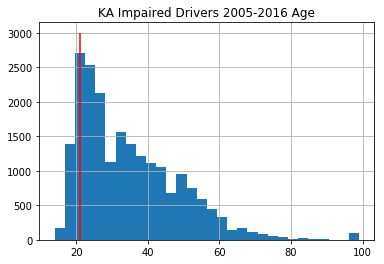

In [5]:
# Age of Impaired Driver
df= pd.concat([K_Occ_DF,A_Occ_DF])
df = df[(df.DR_CON.isin([2,3,6,7])) & (df.PER_TYPE==1)]
plt.hist(df.AGE,bins=30)
plt.vlines(21,0,3000,'red')
plt.grid()
plt.title('2005-2016 KA Impaired Drivers Age')
plt.show()

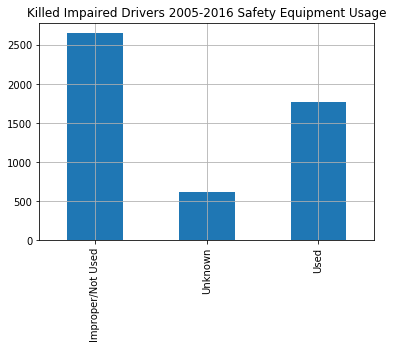

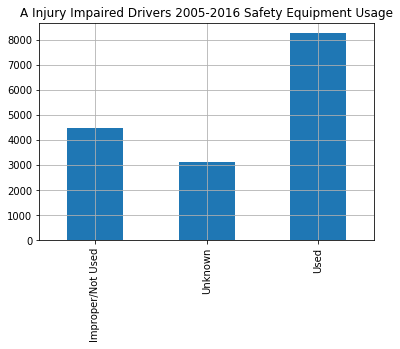

In [5]:
# KA Impaired Drivers Safety Equipment Usage
df= pd.concat([K_Occ_DF])
df = df[(df.DR_CON.isin([2,3,6,7])) & (df.PER_TYPE==1)]
df = df.SafetyEq.value_counts().sort_index()
df.plot(kind='bar')
plt.grid()
plt.title('Killed Impaired Drivers 2005-2016 Safety Equipment Usage')
plt.show()
df= pd.concat([A_Occ_DF])
df = df[(df.DR_CON.isin([2,3,6,7])) & (df.PER_TYPE==1)]
df = df.SafetyEq.value_counts().sort_index()
df.plot(kind='bar')
plt.grid()
plt.title('A Injury Impaired Drivers 2005-2016 Safety Equipment Usage')
plt.show()

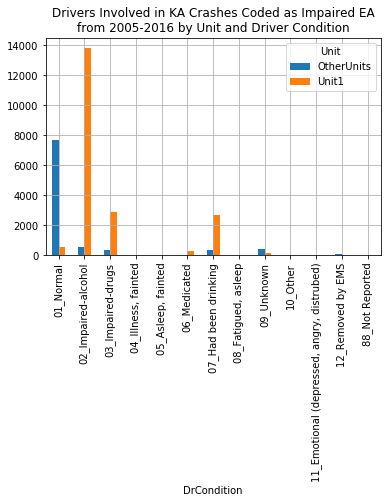

In [8]:
df= pd.concat([K_Occ_DF,A_Occ_DF])
df = hsmpy3.common.PairTable(df[(df.EA_IM==1) & (df.PER_TYPE==1)],['Unit'],['DrCondition']).T
df.plot(kind='bar')
plt.grid()
plt.title('Drivers Involved in KA Crashes Coded as Impaired EA\nfrom 2005-2016 by Unit and Driver Condition')
plt.show()

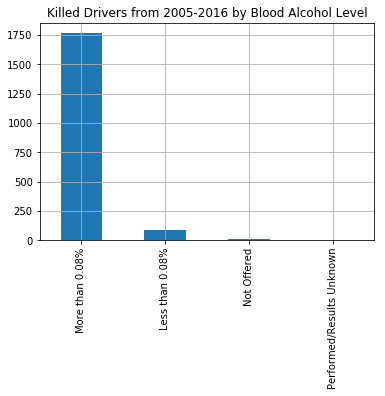

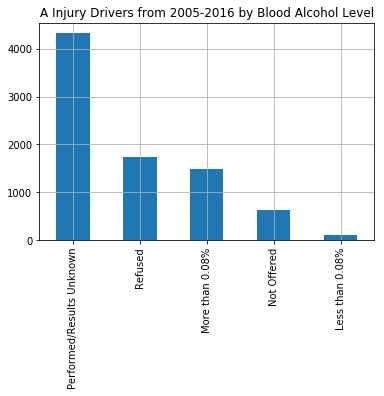

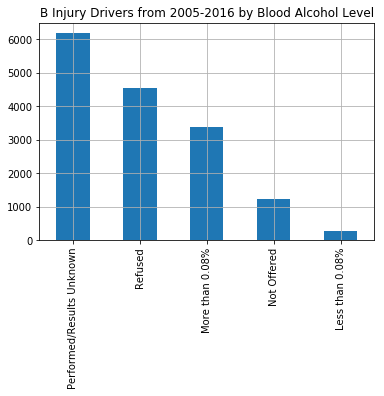

In [21]:
# BAC
df_all = pd.concat([K_Occ_DF,A_Occ_DF,B_Occ_DF])
df = df_all[(df_all.PER_TYPE==1) & (df_all.DR_CON==2) & (df_all.INJ_SEV==4)]
df = df.BloodAlcohol.value_counts()
df.plot(kind='bar')
plt.grid()
plt.title('Killed Drivers from 2005-2016 by Blood Alcohol Level')
plt.show()

df = df_all[(df_all.PER_TYPE==1) & (df_all.DR_CON==2) & (df_all.INJ_SEV==3)]
df = df.BloodAlcohol.value_counts()
df.plot(kind='bar')
plt.grid()
plt.title('A Injury Drivers from 2005-2016 by Blood Alcohol Level')
plt.show()

df = df_all[(df_all.PER_TYPE==1) & (df_all.DR_CON==2) & (df_all.INJ_SEV==2)]
df = df.BloodAlcohol.value_counts()
df.plot(kind='bar')
plt.grid()
plt.title('B Injury Drivers from 2005-2016 by Blood Alcohol Level')
plt.show()


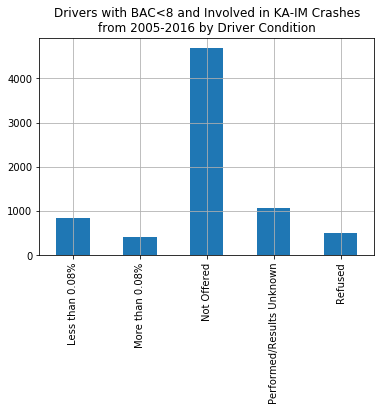

In [23]:
# had been drinking drivers in KAB crashes
df_all = pd.concat([K_Occ_DF,A_Occ_DF,B_Occ_DF])
df = df_all[(df_all.PER_TYPE==1) & (df_all.DR_CON==7)]
df.BloodAlcohol.value_counts().sort_index().plot(kind='bar')
plt.grid()
plt.title('Drivers with BAC<8 and Involved in KA-IM Crashes\nfrom 2005-2016 by Driver Condition')
#plt.vlines(8,0,600,'red')
plt.show()

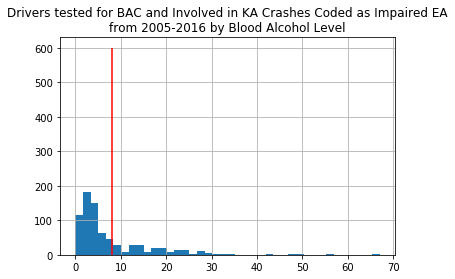

In [28]:
df= pd.concat([K_Occ_DF,A_Occ_DF])
df = df[(df.EA_IM==1) & (df.PER_TYPE==1) & (df.BAC<90) & (df.DR_CON==7)]
plt.hist(df.BAC,bins=40)
plt.grid()
plt.title('Drivers tested for BAC and Involved in KA Crashes Coded as Impaired EA\nfrom 2005-2016 by Blood Alcohol Level')
plt.vlines(8,0,600,'red')
plt.show()

,January,February,March,April,May,June,July,August,September,October,November,December
SeasonalFactor,0.845432,0.755674,0.855217,0.917947,1.100941,1.062103,1.166309,1.165496,1.063514,1.084706,0.988241,0.99442


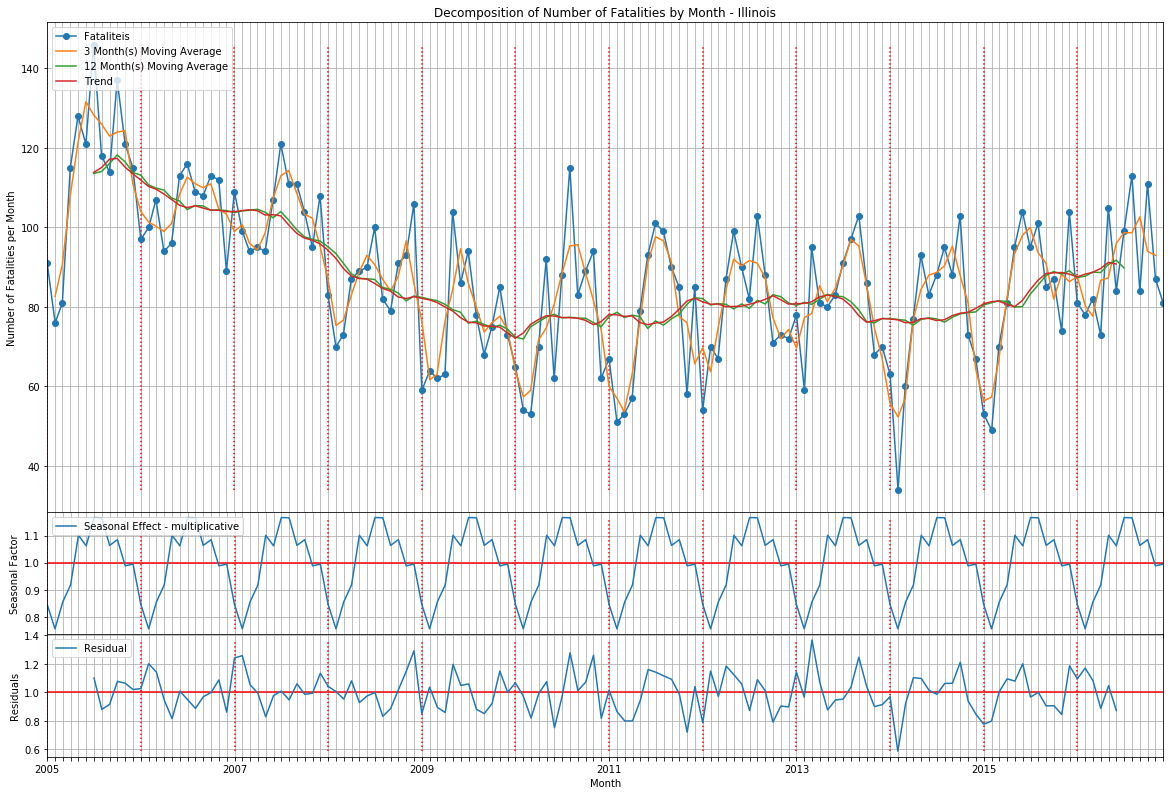

In [166]:
plt.figure(figsize=(20,15))
Model = 'multiplicative'
#Model = 'additive'
N = [3,12]
K_Crash_DF['Month'] = [d.strftime('%Y-%m') for d in K_Crash_DF.DATE]
df = pd.DataFrame(K_Crash_DF.groupby('Month')['K'].aggregate(sum).sort_index())
df.index = pd.to_datetime(df.index)
result = seasonal_decompose(df.K, model=Model)

plt.subplot2grid((6, 1), (0, 0), rowspan=4)
p1 = plt.plot(df,'-o',label='Fataliteis')
for i in range(2005,2018):
    plt.vlines(datetime(i,1,1,0,0),df.K.min(),df.K.max(),'red',':')
for n in N:
    df.K.rolling(window=n,center=True,min_periods=n).mean().plot(label='{} Month(s) Moving Average'.format(n))
result.trend.plot(label='Trend')
plt.xticks(list(df.index),[])
plt.xlabel('')
plt.ylabel('Number of Fatalities per Month')
plt.grid()
plt.title('Decomposition of Number of Fatalities by Month - Illinois')
plt.legend(loc='upper left',fancybox=True)

plt.subplot2grid((6, 1), (4, 0))
result.seasonal.plot(label='Seasonal Effect - {}'.format(Model))
for i in range(2005,2018):
    plt.vlines(datetime(i,1,1,0,0),result.seasonal.min(),result.seasonal.max(),'red',':')
plt.hlines(y={'additive':0,'multiplicative':1}[Model],colors='red',xmin=df.index.min(),xmax=df.index.max())
plt.xticks(list(df.index),[])
plt.xlabel('')
plt.ylabel('Seasonal Factor')
plt.grid()
plt.legend(loc='upper left',fancybox=True)

plt.subplot2grid((6, 1), (5, 0))
result.resid.plot(label='Residual')
for i in range(2005,2018):
    plt.vlines(datetime(i,1,1,0,0),result.resid.min(),result.resid.max(),'red',':')
plt.hlines(y={'additive':0,'multiplicative':1}[Model],colors='red',xmin=df.index.min(),xmax=df.index.max())
plt.xticks(df.index)
plt.ylabel('Residuals')
plt.legend(loc='upper left',fancybox=True)
plt.grid()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('Decomposition.png',transparent=True,dpi=1200)

mdf = pd.DataFrame(result.seasonal.iloc[0:12])
mdf.columns = ['SeasonalFactor']
mdf.index = [d.strftime('%B') for d in mdf.index]
mdf = mdf.T
display(mdf)

plt.show()

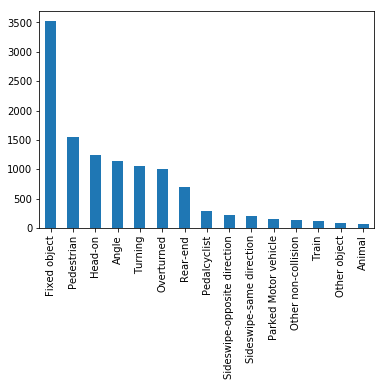

In [171]:
pd.Series([hsmpy3.il.domains.COL_TYPE['codes'][s] for s in  K_Crash_DF.COL_TYPE]).value_counts().plot(kind='bar')
plt.show()

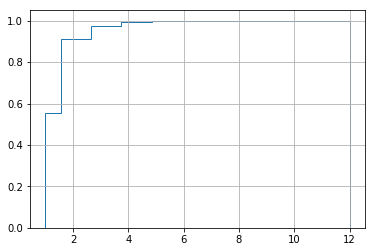

In [180]:
plt.hist(K_Crash_DF.NO_VEH,cumulative=True,density=True,histtype='step',bins=20)
plt.grid()
plt.show()

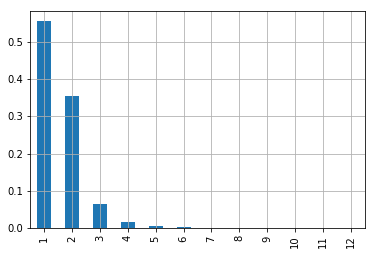

In [182]:
K_Crash_DF.NO_VEH.value_counts(True).sort_index().plot(kind='bar')
plt.grid()
plt.show()